In [120]:
%matplotlib inline

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.linear_model import LogisticRegression, RANSACRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, RocCurveDisplay

In [122]:
RANDOM_STATE = 1

# Sumo Bouts Prediction (part 2)

1. Explore data.
1. Model data.
    - prepare data
    - extract the latest 2 tournaments to use as test
    - select a subset of predictors from all features
        - with "delta" features or without them
    - prepare folds
    - prepare scorer
    - model selection
    - test the model on a subset of the original data - only recent bouts (from 2000) 

## Explore data

### Read and get to know

In [123]:
sumo = pd.read_csv("cleaned_sumo2.csv")

In [124]:
sumo = sumo.drop(columns='Unnamed: 0')

In [125]:
sumo.shape

(129600, 63)

In [126]:
sumo.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [127]:
sumo.tail()

,year,month,day,id1,age1,height1,weight1,bmi1,rank1_A,rank1_B,...,height_delta,weight_delta,previous_tournament_win_percentage_delta,previous_tournament_bouts_delta,rank_A_delta,rank_B_delta,career_bouts_delta,career_win_percentage_delta,tournament_win_percentage_delta,tournament_win_rolling_delta
129595,2022,9,15,12370,27.737736,180.0,129.0,38.579074,19,4,...,-2.0,-10.0,0.066667,0,6,2,-419,0.135548,0.071429,0.024529
129596,2022,9,15,11980,28.906822,187.0,143.0,38.875445,12,1,...,8.0,-29.0,0.114286,8,-8,-4,-528,-0.010506,0.357143,0.665741
129597,2022,9,15,12210,29.684388,179.0,172.0,52.160197,20,5,...,-8.0,29.0,-0.114286,-8,8,4,528,0.010506,-0.357143,-0.665741
129598,2022,9,15,12130,30.823357,184.0,170.0,48.122448,20,5,...,9.0,-13.0,-0.066667,0,0,0,137,-0.092485,-0.357143,0.057936
129599,2022,9,15,12191,26.073088,175.0,183.0,58.721795,20,5,...,-9.0,13.0,0.066667,0,0,0,-137,0.092485,0.357143,-0.057936


In [128]:
# Test
assert sumo.isna().sum().sum() == 0, "NA values are present"

### Distributions

We want to know how the differences in performance and characteristics are distributed. More precisely, how a wrestler who ultimately won the bout compared to his oponent. We hypothesize that good predictor variables shall have skewed distribution reflecting the difference in level / ability.

The largest absolute skew is for `career_win_percentage_delta`. It is > 0.5, it is possitive meaning the distribution is skewed to the left. This makes sense as the a loosing oponent is likely to have less success in his carreer therefore the difference will be negative.

In [129]:
delta_columns = [
   'age_delta', 'bmi_delta', 'height_delta', 'weight_delta',
   'previous_tournament_win_percentage_delta',
   'rank_A_delta', 'rank_B_delta',
   'career_bouts_delta', 'career_win_percentage_delta',
   'tournament_win_percentage_delta', 'tournament_win_rolling_delta'
]

sumo_for_distribution = sumo[sumo.bout_outcome1 == 1][delta_columns]

In [130]:
sumo_for_distribution.skew().round(2)

age_delta                                   0.00
bmi_delta                                   0.00
height_delta                                0.07
weight_delta                                0.06
previous_tournament_win_percentage_delta    0.03
rank_A_delta                               -0.14
rank_B_delta                                0.21
career_bouts_delta                         -0.05
career_win_percentage_delta                 0.67
tournament_win_percentage_delta             0.13
tournament_win_rolling_delta                0.03
dtype: float64

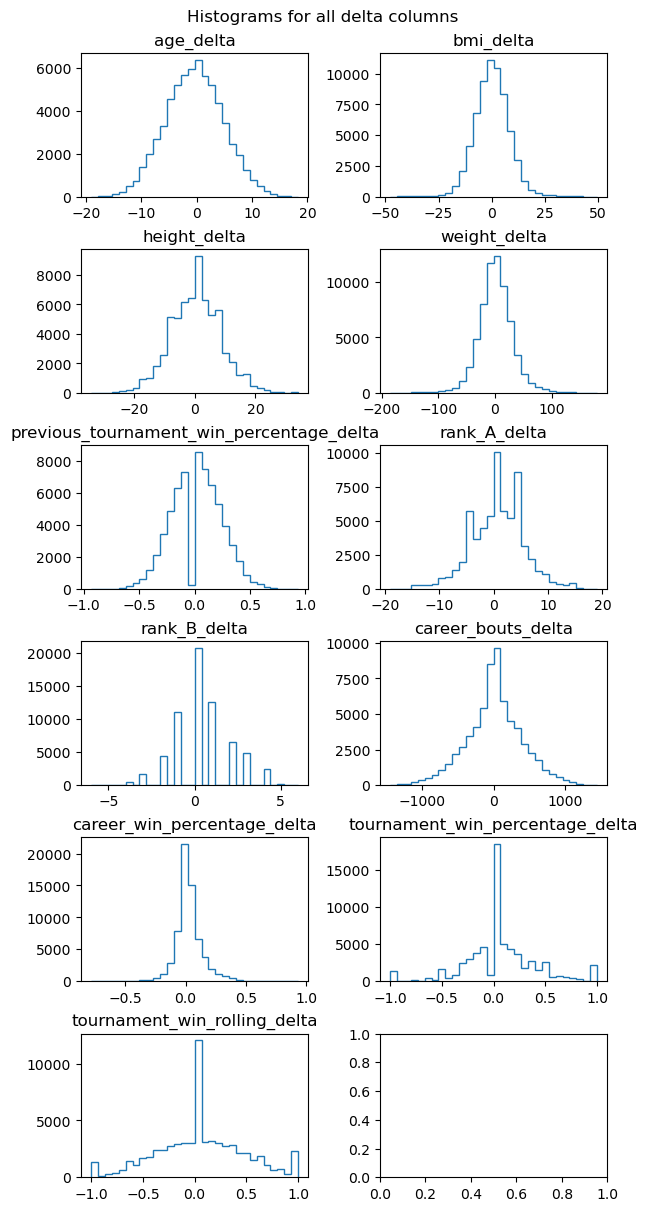

In [131]:
def plot_histograms(df, title="", ncols=2, bins=30):
    single_width = 3
    single_height = 2
    nrows = len(df.columns) // ncols + 1
    fig, axs = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        constrained_layout=True,
        figsize=(single_width * ncols, single_height * nrows)
    )

    for ax, column in zip(axs.flatten(), df.columns):
        ax.hist(df[column], bins=bins, histtype="step")
        ax.set_title(column)

    fig.suptitle(title)
    plt.show()

plot_histograms(sumo_for_distribution, "Histograms for all delta columns")

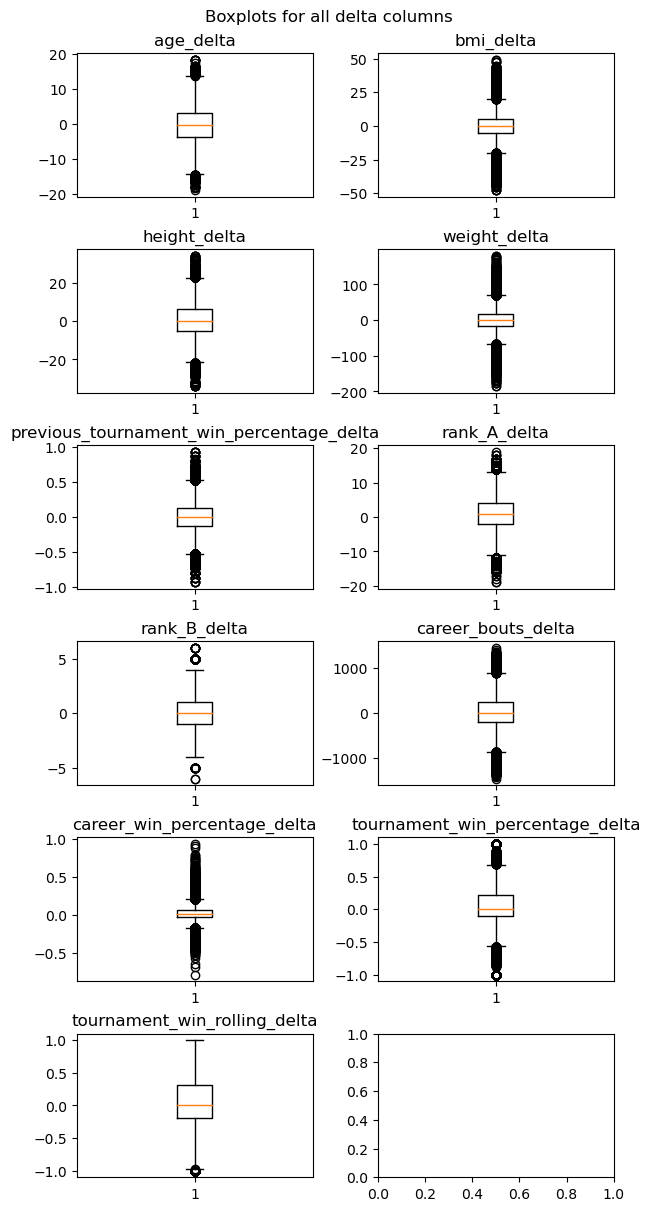

In [132]:
def plot_boxplots(df, title="", ncols=2):
    single_width = 3
    single_height = 2
    nrows = len(df.columns) // ncols + 1
    fig, axs = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        constrained_layout=True,
        figsize=(single_width * ncols, single_height * nrows)
    )

    for ax, column in zip(axs.flatten(), df.columns):
        ax.boxplot(df[column])
        ax.set_title(column)

    fig.suptitle(title)
    plt.show()
    
plot_boxplots(sumo_for_distribution, "Boxplots for all delta columns")

### Proportions

The label variable we will be predicting - `bout_outcome1` - is the wins of the first wrestler. The numbers of wins (1) and losses (0) in the data is exactly equal. This is expected - each encounter or fight is recorded twice from the prospective of each wrestler.

In [133]:
def pie_plot_categories(data, title, figsize=(4,3)):
    plt.figure(figsize=figsize)
    plt.pie(data, labels=data.index, autopct="%.1f")
    plt.title(title)
    plt.show()

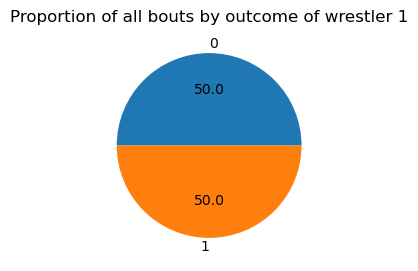

In [134]:
by_bout_outcome1 = sumo.bout_outcome1.value_counts()
pie_plot_categories(by_bout_outcome1, "Proportion of all bouts by outcome of wrestler 1")

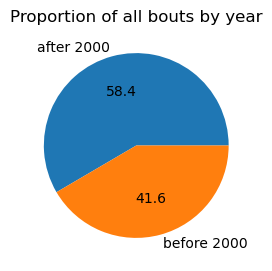

In [135]:
by_year = pd.Series(
    data=[len(sumo[sumo.year >= 2000]), len(sumo[sumo.year < 2000])], 
    index=["after 2000", "before 2000"],
)

pie_plot_categories(by_year, "Proportion of all bouts by year")

### Correlations

Check if the encounter performance (`encounter_win_percentage1`, `encounter_win_rolling1`) is correlated with the differences in skill, performance, and physical characteristics discrepancy between the oponents.

Observations: no major correlations. Some obvious ones e.g. `age_delta` and `career_bouts_delta` - the higher the age difference, the higher the total number of played bouts difference.

In [136]:
variables_for_correlation = [
    'encounter_win_percentage1', 'encounter_win_rolling1',
    'age_delta', 'bmi_delta', 'height_delta', 'weight_delta',
    'previous_tournament_win_percentage_delta',
    'previous_tournament_bouts_delta', 'rank_A_delta', 'rank_B_delta',
    'career_bouts_delta', 'career_win_percentage_delta',
    'tournament_win_percentage_delta', 'tournament_win_rolling_delta'
]

In [137]:
def plot_pearson(df, width=12, height=12, title=""):
    pear_corr = sumo_for_corr.corr()
    pear_corr_triangular = pear_corr.where(np.tril(np.ones(pear_corr.shape)).astype("bool"))

    plt.imshow(pear_corr_triangular, cmap='BrBG', vmin=-1, vmax=1)
    plt.colorbar()

    ticks = np.arange(len(pear_corr_triangular))
    labels = pear_corr_triangular.columns
    plt.yticks(ticks, labels)
    plt.xticks(ticks, labels, rotation='vertical')

    ax = plt.gca()
    ax.figure.set_figwidth(width)
    ax.figure.set_figheight(height)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.title(title)
    plt.show()

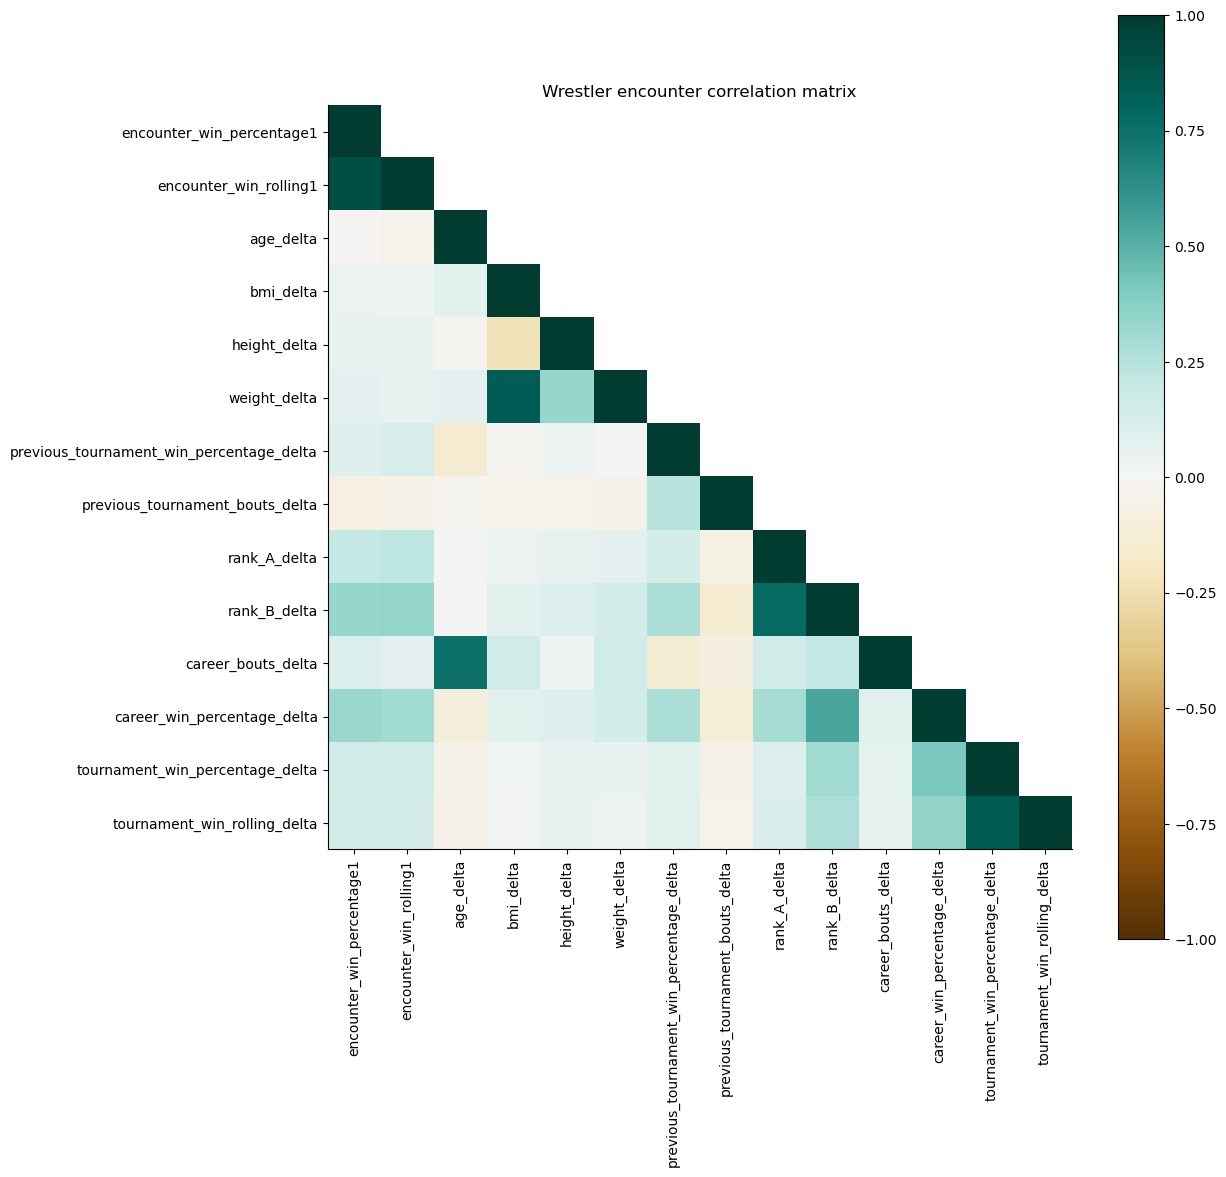

In [138]:
sumo_for_corr = sumo[sumo.bout_outcome1 == 1][variables_for_correlation]
plot_pearson(sumo_for_corr, title="Wrestler encounter correlation matrix")

## Model data

### Preprocess

#### Extract the latest 2 tournaments

The most recent tournaments (July and September 2022) are removed from the dataset. They will be used as testing sets of the final model.

In [139]:
def get_tournament(year, month):
    return sumo[(sumo.year == year) & (sumo.month == month)]

september_tournament = get_tournament(2022, 9)
july_tournament = get_tournament(2022, 7)

sumo = pd.concat([sumo[sumo.year < 2022], sumo[(sumo.year == 2022) & (sumo.month <= 5)]])

#### Choose a subset of features

The first task is to select a feature subset for modeling. We engineered multiple features in the previous notebook. However, the information is somewhat repeated. For example:
1) there are rows for wins, losses, total bouts, win percentage (wins/total bouts)
2) while each wrestler has characteristics, we calculated their differances (deltas) as well

Regarding 1), in addition to the win percentage we inlcude absolute number of wins, bouts. 

`original_columns` - helper set of columns, used as baseline to filter out a specific set of predictor variables

`predictors_1` - the first subset that we will compare, it countains wrestler 1 data and the deltas. 

`predictors_2` - the second subset, instead of the differances (deltas) it contains the wrestler 2 attributes

In [140]:
original_columns = [
    # Tournament
    "year",
    "month",
    "day",

    # Wrestler 1

    "id1",
    "age1",
    "height1",
    "weight1",
    "bmi1",
    "rank1_A",
    "rank1_B",
    "bout_outcome1",

    "tournament_wins1",
    "tournament_losses1",
    "tournament_bouts1",
    "tournament_win_percentage1",
    "tournament_win_rolling1",

    "previous_tournament_wins1",
    "previous_tournament_losses1",
    "previous_tournament_bouts1",
    "previous_tournament_win_percentage1",

    "career_wins1",
    "career_bouts1",
    "career_win_percentage1",

    "encounter_wins1",
    "encounter_win_percentage1",
    "encounter_win_rolling1",



    # Wrestler 2

    "id2",
    "age2",
    "height2",
    "weight2",
    "bmi2",
    "rank2_A",
    "rank2_B",
    "bout_outcome2",

    "tournament_wins2",
    "tournament_losses2",
    "tournament_bouts2",
    "tournament_win_percentage2",
    "tournament_win_rolling2",

    "previous_tournament_wins2",
    "previous_tournament_losses2",
    "previous_tournament_bouts2",
    "previous_tournament_win_percentage2",

    "career_wins2",
    "career_bouts2",
    "career_win_percentage2",

    "encounter_wins2",
    "encounter_win_percentage2",
    "encounter_win_rolling2",


    # Encounter variables
    "encounter_id1",
    "encounter_bouts",


    # Deltas

    "age_delta",
    "bmi_delta",
    "height_delta",
    "weight_delta",

    "previous_tournament_win_percentage_delta",
    "previous_tournament_bouts_delta",

    "rank_A_delta",
    "rank_B_delta",

    "career_bouts_delta",
    "career_win_percentage_delta",

    "tournament_win_percentage_delta",
    "tournament_win_rolling_delta",
]

assert set(original_columns) == set(sumo.columns), "`sumo` columns do not match the values in `original_columns`"

In [141]:
predictors_1 = [
    # Tournament
    # "year",
    # "month",
    # "day",

    # Wrestler 1

    # "id1",
    "age1",
    "height1",
    "weight1",
    "bmi1",
    # "rank1_A",
    "rank1_B",
    # "bout_outcome1",

    "tournament_wins1",
    # "tournament_losses1",
    "tournament_bouts1",
    "tournament_win_percentage1",
    "tournament_win_rolling1",

    "previous_tournament_wins1",
    # "previous_tournament_losses1",
    "previous_tournament_bouts1",
    "previous_tournament_win_percentage1",

    "career_wins1",
    "career_bouts1",
    "career_win_percentage1",

    "encounter_wins1",
    "encounter_win_percentage1",
    "encounter_win_rolling1",



    # Wrestler 2

#     "id2",
#     "age2",
#     "height2",
#     "weight2",
#     "bmi2",
#     "rank2_A",
#     "rank2_B",
#     "bout_outcome2",

#     "tournament_wins2",
#     "tournament_losses2",
#     "tournament_bouts2",
#     "tournament_win_percentage2",
#     "tournament_win_rolling2",

#     "previous_tournament_wins2",
#     "previous_tournament_losses2",
#     "previous_tournament_bouts2",
#     "previous_tournament_win_percentage2",

#     "career_wins2",
#     "career_bouts2",
#     "career_win_percentage2",

#     "encounter_wins2",
#     "encounter_win_percentage2",
#     "encounter_win_rolling2",


    # Encounter variables
    # "encounter_id1",
    "encounter_bouts",


    # Deltas

    "age_delta",
    "bmi_delta",
    "height_delta",
    "weight_delta",

    "previous_tournament_win_percentage_delta",
    "previous_tournament_bouts_delta",

    "rank_A_delta",
    "rank_B_delta",

    "career_bouts_delta",
    "career_win_percentage_delta",

    "tournament_win_percentage_delta",
    "tournament_win_rolling_delta",
]

In [142]:
predictors_2 = [
    # Tournament
    # "year",
    # "month",
    # "day",

    # Wrestler 2

    # "id1",
    "age1",
    "height1",
    "weight1",
    "bmi1",
    "rank1_A",
    "rank1_B",
    # "bout_outcome1",

    "tournament_wins1",
    "tournament_losses1",
    "tournament_bouts1",
    "tournament_win_percentage1",
    "tournament_win_rolling1",

    "previous_tournament_wins1",
    "previous_tournament_losses1",
    "previous_tournament_bouts1",
    "previous_tournament_win_percentage1",

    "career_wins1",
    "career_bouts1",
    "career_win_percentage1",

    "encounter_wins1",
    "encounter_win_percentage1",
    "encounter_win_rolling1",

    # Wrestler 2
    # "id2",
    "age2",
    "height2",
    "weight2",
    "bmi2",
    "rank2_A",
    "rank2_B",
    # "bout_outcome2",

    "tournament_wins2",
    "tournament_losses2",
    "tournament_bouts2",
    "tournament_win_percentage2",
    "tournament_win_rolling2",

    "previous_tournament_wins2",
    "previous_tournament_losses2",
    "previous_tournament_bouts2",
    "previous_tournament_win_percentage2",

    "career_wins2",
    "career_bouts2",
    "career_win_percentage2",

    "encounter_wins2",
    "encounter_win_percentage2",
    "encounter_win_rolling2",

    # Encounter variables
    # "encounter_id1",
    "encounter_bouts",

    # Deltas
    # "age_delta",
    # "bmi_delta",
    # "height_delta",
    # "weight_delta",

    # "previous_tournament_win_percentage_delta",
    # "previous_tournament_bouts_delta",

    # "rank_A_delta",
    # "rank_B_delta",

    # "career_bouts_delta",
    # "career_win_percentage_delta",

    # "tournament_win_percentage_delta",
    # "tournament_win_rolling_delta",
]

In [143]:
sumo_with_predictors_1 = sumo[predictors_1]
sumo_with_predictors_2 = sumo[predictors_2]
bout_outcomes = sumo.bout_outcome1

In [144]:
pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("logreg", LogisticRegression()),
])

In [145]:
def fit_and_print_reports(X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=10_000, stratify=y)
    
    model.fit(X_train, y_train)
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.plot([0,1], [0,1], 'b-')
    plt.show()
    
    print("Report on train data\n", classification_report(y_train, model.predict(X_train)))
    print("Report on test data\n", classification_report(y_test, model.predict(X_test)))

C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


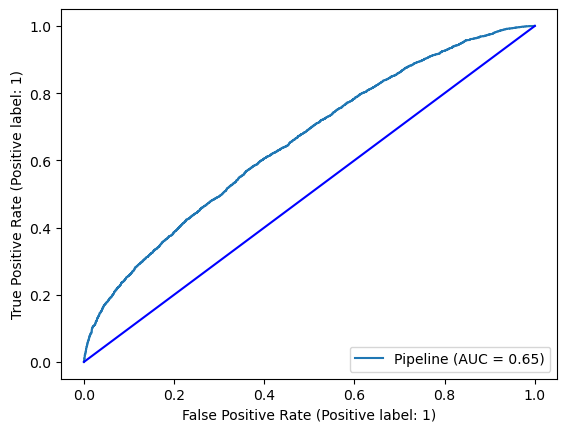

Report on train data
               precision    recall  f1-score   support

           0       0.60      0.60      0.60     59256
           1       0.60      0.60      0.60     59256

    accuracy                           0.60    118512
   macro avg       0.60      0.60      0.60    118512
weighted avg       0.60      0.60      0.60    118512

Report on test data
               precision    recall  f1-score   support

           0       0.60      0.60      0.60      5000
           1       0.60      0.60      0.60      5000

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.60     10000
weighted avg       0.60      0.60      0.60     10000



C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


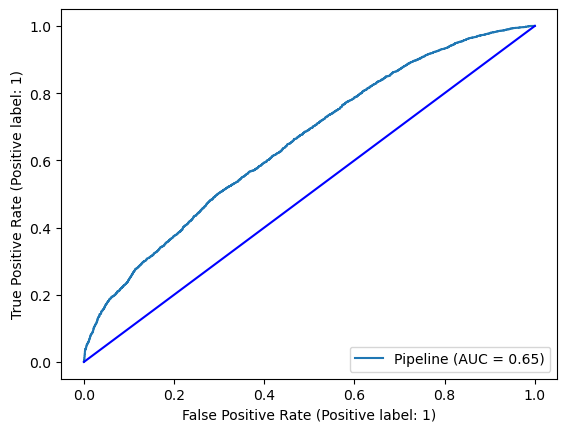

Report on train data
               precision    recall  f1-score   support

           0       0.60      0.60      0.60     59256
           1       0.60      0.60      0.60     59256

    accuracy                           0.60    118512
   macro avg       0.60      0.60      0.60    118512
weighted avg       0.60      0.60      0.60    118512

Report on test data
               precision    recall  f1-score   support

           0       0.60      0.60      0.60      5000
           1       0.60      0.59      0.60      5000

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.60     10000
weighted avg       0.60      0.60      0.60     10000



In [146]:
fit_and_print_reports(sumo_with_predictors_1, bout_outcomes, pipe)
fit_and_print_reports(sumo_with_predictors_2, bout_outcomes, pipe)

In [149]:
pipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("logreg", LogisticRegression()),
])

params = {
    "logreg__C": [0.001, 100, 10e6],
    "logreg__max_iter": [100, 200],
    "logreg__penalty": ['l1', 'l2', 'elasticnet',],
}

def fit_grid_search_and_print_reports(attributes):
    grid_search = GridSearchCV(pipe, params, cv = 4, scoring="f1")

    X_train, X_test, y_train, y_test = train_test_split(
        attributes, bout_outcomes, test_size=10_000, stratify=bout_outcomes)

    grid_search.fit(X_train, y_train)

    print("Best params: ", grid_search.best_params_)
    print("Report on train data\n", classification_report(y_train, grid_search.predict(X_train)))
    print("Report on test data\n", classification_report(y_test, grid_search.predict(X_test)))

In [150]:
print("Report with Predictors set #1\n", "="*30)
fit_grid_search_and_print_reports(sumo_with_predictors_1)

print("Report with Predictors set #2\n", "="*30)
fit_grid_search_and_print_reports(sumo_with_predictors_2)

Report with Predictors set #1


C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

Best params:  {'logreg__C': 100, 'logreg__max_iter': 100, 'logreg__penalty': 'l2'}
Report on train data
               precision    recall  f1-score   support

           0       0.60      0.60      0.60     59256
           1       0.60      0.60      0.60     59256

    accuracy                           0.60    118512
   macro avg       0.60      0.60      0.60    118512
weighted avg       0.60      0.60      0.60    118512

Report on test data
               precision    recall  f1-score   support

           0       0.59      0.59      0.59      5000
           1       0.59      0.59      0.59      5000

    accuracy                           0.59     10000
   macro avg       0.59      0.59      0.59     10000
weighted avg       0.59      0.59      0.59     10000

Report with Predictors set #2


C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

Best params:  {'logreg__C': 10000000.0, 'logreg__max_iter': 100, 'logreg__penalty': 'l2'}
Report on train data
               precision    recall  f1-score   support

           0       0.60      0.60      0.60     59256
           1       0.60      0.60      0.60     59256

    accuracy                           0.60    118512
   macro avg       0.60      0.60      0.60    118512
weighted avg       0.60      0.60      0.60    118512

Report on test data
               precision    recall  f1-score   support

           0       0.61      0.61      0.61      5000
           1       0.61      0.60      0.61      5000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



Observations:
- Similar predictive capability - f1 score is ~0.60.
- The logistic regression performance is poor. The scores are almost identical for the train and test data. Also, the scores are rather low (=bias is high). Therefore, the logistic regression (even after optimization) is underfitting. The root cause may be the data, the model or model type. Possible solutions - try different models, use less rows (e.g. only those since year 2000.)
- `predictors_1` contains "delta" features, `predictors_2` does not.
- C is slightly higher for `predictors_1` -> less regularization -> features are taken "with more weight".

Conclusion: `predictors_1` are taken with more weight and are therefore better. Continue using them.

#### Try to reduce bias by fitting less rows

Conclusion: fitting the model with less data does not reduce the bias.

In [ ]:
recent_sumo_with_predictors_1 = sumo[sumo.year >= 2000][predictors_1]
recent_sumo_with_predictors_2 = sumo[sumo.year >= 2000][predictors_2]
recent_bout_outcomes = sumo[sumo.year >= 2000].bout_outcome1

In [ ]:
fit_and_print_reports(recent_sumo_with_predictors_1, recent_bout_outcomes, pipe)
fit_and_print_reports(recent_sumo_with_predictors_2, recent_bout_outcomes, pipe)

In [ ]:
def fit_grid_search_and_print_reports(attributes, labels):
    pipe = Pipeline([
        ("scaler", MinMaxScaler()),
        ("logreg", LogisticRegression()),
    ])
    params = {
        "logreg__C": [0.001, 1, 100, 10e4, 10e6],
        "logreg__max_iter": [200, 400],
        "logreg__penalty": ['l1', 'l2', 'elasticnet',],
    }
    grid_search = GridSearchCV(pipe, params, cv = 4, scoring="f1")

    test_size = 10_000
    X_train, X_test, y_train, y_test = train_test_split(
        attributes, labels, test_size=test_size, stratify=labels)

    grid_search.fit(X_train, y_train)

    print("Best params: ", grid_search.best_params_)
    print("Report on train data\n", classification_report(y_train, grid_search.predict(X_train)))
    print("Report on test data\n", classification_report(y_test, grid_search.predict(X_test)))

In [ ]:
print("Report with Predictors set #1\n", "="*30)
fit_grid_search_and_print_reports(recent_sumo_with_predictors_1, recent_bout_outcomes)

print("Report with Predictors set #2\n", "="*30)
fit_grid_search_and_print_reports(recent_sumo_with_predictors_2, recent_bout_outcomes)

#### Define folds, scorer, and data splits

Steps are described below.
1. Define a helper function to print classification reports for the training and test sets. It will plot the classification reports for both training and test set and also plot the ROC curve.
1. Create cross-validation folds. Our data set is moderate in size, 4 folds seem reasonable.
1. Create scorer (f1). Even though we are are interested in the wrestler winning (possitive class is "1"), F1 seems suitable since the two classes / labels have equal size. We will however judge most models tested below by looking at the classification report that contains all confussion matrix results.
1. Extract the predictor and predicted variables (attributes and labels). Split in training and tets subsets. 10K seems a reasonable test set size given the size of the dataset (~125K).

In [151]:
def print_results(fitted_model, X_train, X_test, y_train, y_test):
    print("Classification report, training data\n")
    report = classification_report(
        y_true=y_train,
        y_pred=fitted_model.predict(X_train),
    )
    print(report)

    print("Classification report, test data\n")
    report = classification_report(
        y_true=y_test,
        y_pred=fitted_model.predict(X_test),
    )
    print(report)
    
    RocCurveDisplay.from_estimator(fitted_model, X_test, y_test)
    plt.plot([0,1], [0,1], c="gray", lw=1, ls="--")
    plt.title("ROC curve")
    plt.show()    

In [152]:
k_fold = StratifiedKFold(
    n_splits=4,
    shuffle=True,
    random_state=RANDOM_STATE
)

In [153]:
f1_scorer = make_scorer(
    score_func=f1_score,
    pos_label=1,
)

In [154]:
# Extract predictors and outputs
sumo_labels = sumo.bout_outcome1
sumo_attributes = sumo[predictors_1]

# Scale
scaler = MinMaxScaler()
sumo_attributes_scaled = scaler.fit_transform(sumo_attributes)

# Split
X_train, X_test, y_train, y_test = train_test_split(
        sumo_attributes_scaled, sumo_labels, test_size=10_000, stratify=sumo_labels)

In [155]:
# Test
assert sumo.bout_outcome1.nunique() == 2, "The number of classes is different than 2."

In [156]:
# Test - print folds
for train_indeces, test_indeces in k_fold.split(X_train, y_train):
    print(
        f"train set indeces: {train_indeces.min()} - {train_indeces.max()}",
        f"test set indeces: {test_indeces.min()} - {test_indeces.max()}",
        "=" * 30,
        sep="\n",
    )

train set indeces: 0 - 118510
test set indeces: 1 - 118511
train set indeces: 1 - 118511
test set indeces: 0 - 118504
train set indeces: 0 - 118511
test set indeces: 10 - 118509
train set indeces: 0 - 118511
test set indeces: 13 - 118510


### Logistic regression

Fit again a logistic regression. Less hyper-parameters are used to tune up given the experience from the previous models.

In [33]:
params = {
    "C": [10e4, 10e6, 10e8],
    "max_iter": [300, 500,],
}

grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=params,
    cv=k_fold,
    scoring=f1_scorer,
)
grid_search.fit(X_train, y_train)

C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=1, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [100000.0, 10000000.0, 1000000000.0],
                         'max_iter': [300, 500]},
             scoring=make_scorer(f1_score, pos_label=1))

In [34]:
best_lr = grid_search.best_estimator_

In [35]:
grid_search.best_params_

{'C': 10000000.0, 'max_iter': 300}

Classification report, training data

              precision    recall  f1-score   support

           0       0.60      0.60      0.60     59256
           1       0.60      0.60      0.60     59256

    accuracy                           0.60    118512
   macro avg       0.60      0.60      0.60    118512
weighted avg       0.60      0.60      0.60    118512

Classification report, test data

              precision    recall  f1-score   support

           0       0.60      0.60      0.60      5000
           1       0.60      0.59      0.60      5000

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.60     10000
weighted avg       0.60      0.60      0.60     10000



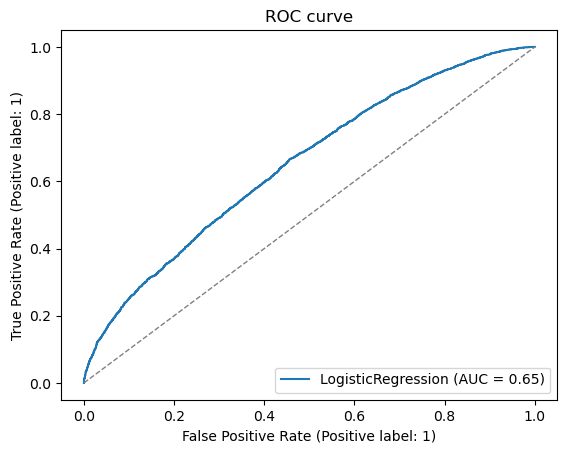

In [36]:
print_results(best_lr, X_train, X_test, y_train, y_test)

#### Intepret weight coefficients

Observations:
- The majority of features with high weight are "delta" features. 

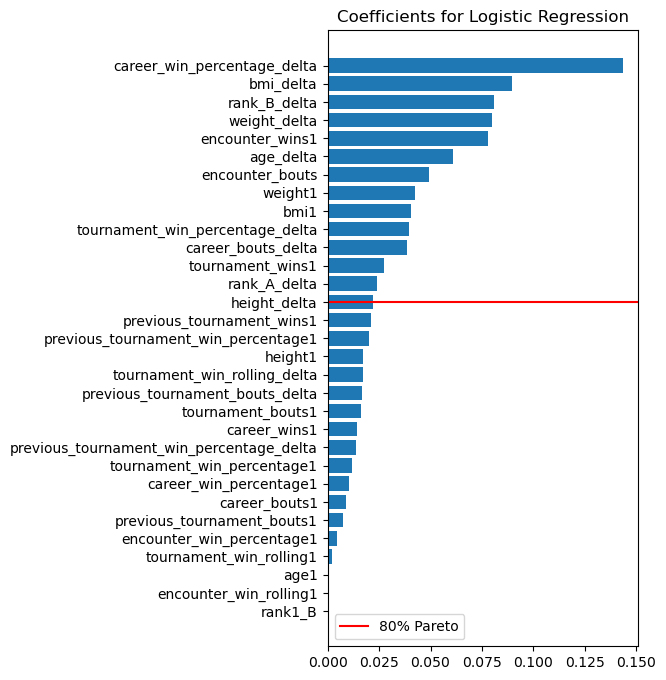

In [37]:
weights = pd.Series(
    data=best_lr.coef_[0],
    index=predictors_1,
)
weights_abs = np.abs(weights)
weights_abs = weights_abs.sort_values()

plt.figure(figsize=(4, 8))
plt.barh(
    y=weights_abs.index, 
    width=weights_abs.values / weights_abs.sum(),
)
pareto_80 = len(weights_abs[(weights_abs.cumsum() / weights_abs.sum()) < 0.2])
plt.axhline(pareto_80, c="r", label="80% Pareto")
plt.title("Coefficients for Logistic Regression")
plt.legend()
plt.show()

#### Remove outliers (RANSAC)

Try to improve the score by removing the outliers from the best logistic regression after the tune-up from above using RANSAC.

##### Fit and score

There are 31 input variables, therefore lets set RANSAC parameter `min_samples=40`.

In [40]:
X_train.shape

(118512, 31)

In [42]:
ransac = RANSACRegressor(
    estimator=best_lr,
    min_samples=40,
)

best_ransac = ransac.fit(X_train, y_train)

C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

In [43]:
best_ransac_lr = best_ransac.estimator_

Classification report, training data

              precision    recall  f1-score   support

           0       0.57      0.61      0.59     59256
           1       0.58      0.54      0.56     59256

    accuracy                           0.57    118512
   macro avg       0.57      0.57      0.57    118512
weighted avg       0.57      0.57      0.57    118512

Classification report, test data

              precision    recall  f1-score   support

           0       0.57      0.61      0.58      5000
           1       0.58      0.53      0.55      5000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.57     10000
weighted avg       0.57      0.57      0.57     10000



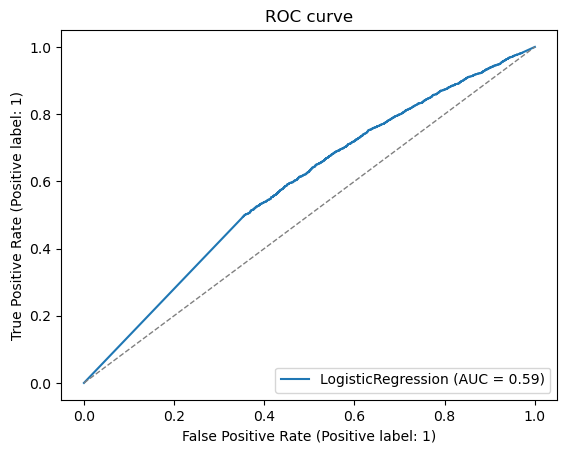

In [44]:
print_results(best_ransac_lr, X_train, X_test, y_train, y_test)

##### Compare feature weights

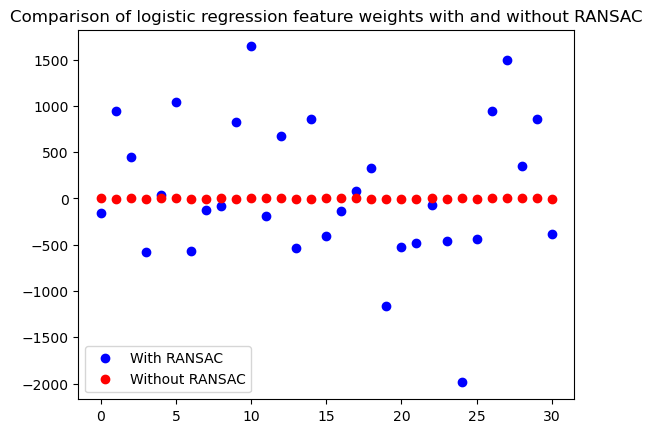

In [45]:
ransac_coef = best_ransac_lr.coef_.ravel()
linreg_coef = best_lr.coef_.ravel()

plt.plot(range(len(ransac_coef)), ransac_coef, 'bo', label='With RANSAC')
plt.plot(range(len(linreg_coef)), linreg_coef, 'ro', label='Without RANSAC')

plt.title("Comparison of logistic regression feature weights with and without RANSAC")
plt.legend()
plt.show()

##### Count outliers

Almost half of all records are reported as outliers when applying RANSAC to the optimized logistic regression. This indicates the model type is not suitable. Another indicator is the high bias observed when fitting the log reg the first time.

In [47]:
# RANSAC inliers
X_train_inliers = X_train[best_ransac.inlier_mask_]
y_train_inliers = y_train[best_ransac.inlier_mask_]

# RANSAC outliers
X_train_outliers = X_train[~best_ransac.inlier_mask_]
y_train_outliers = y_train[~best_ransac.inlier_mask_]

print(f"\nInliers count: {len(X_train_inliers)}")
print(f"Outliers count: {len(X_train_outliers)}")


Inliers count: 67823
Outliers count: 50689


##### Compare scores

The inliners are fitted perfectly and the outliers are not fitted at all. These values are limit values, there might be patterns in both groups so it may be helpful to dig a little deeper and explore the results (TODO). However, lets first try finding more accurate model.

In [48]:
# Logistic regression accuracy, all records (without RANSAC)
lr_accuracy = best_lr.score(X_train, y_train)

# Logistic regression accuracy, outliers removed (with RANSAC)
ransac_accuracy = best_ransac_lr.score(X_train, y_train)

# Accuracy of inliers and outliers only
ransac_inlier_accuracy = best_ransac_lr.score(X_train_inliers, y_train_inliers)
ransac_outlier_accuracy = best_ransac_lr.score(X_train_outliers, y_train_outliers)

print(
    "R_squared Comparison Training Data",
    "-" * 30,
    f"Without RANSAC: {lr_accuracy:.2f}",
    f"With RANSAC, all data: {ransac_accuracy:.2f}",
    f"With RANSAC, inliers only: {ransac_inlier_accuracy:.2f}",
    f"With RANSAC, outliers only: {ransac_outlier_accuracy:.2f}",
    sep="\n",
)

R_squared Comparison Training Data
------------------------------
Without RANSAC: 0.60
With RANSAC, all data: 0.57
With RANSAC, inliers only: 1.00
With RANSAC, outliers only: 0.00


##### Fit using polynomial features

No significant inprovement. Not surprising given the model is "weak" in the first place.

In [49]:
pipe_poly2 = Pipeline([
    ("scaler", scaler),
    ("poly", PolynomialFeatures(degree=2)),
    ("logreg", best_lr),   
])

In [50]:
pipe_poly2.fit(X_train, y_train)

C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaler', MinMaxScaler()), ('poly', PolynomialFeatures()),
                ('logreg', LogisticRegression(C=10000000.0, max_iter=300))])

Classification report, training data

              precision    recall  f1-score   support

           0       0.61      0.62      0.61     59256
           1       0.61      0.61      0.61     59256

    accuracy                           0.61    118512
   macro avg       0.61      0.61      0.61    118512
weighted avg       0.61      0.61      0.61    118512

Classification report, test data

              precision    recall  f1-score   support

           0       0.61      0.63      0.62      5000
           1       0.62      0.61      0.61      5000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.62     10000
weighted avg       0.62      0.62      0.62     10000



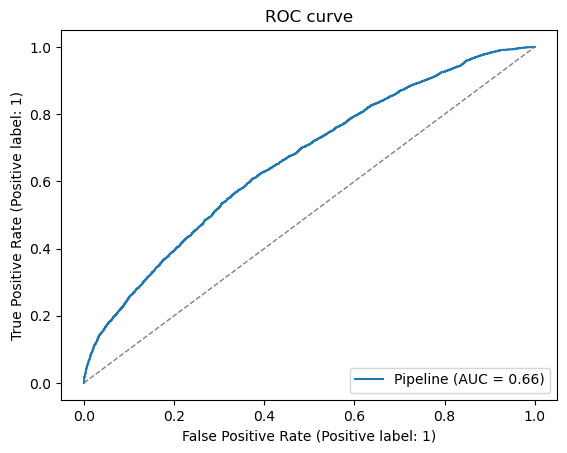

In [51]:
print_results(pipe_poly2, X_train, X_test, y_train, y_test)

### Decition tree

In [53]:
param_grid = {
    "max_depth": [10, 30],
    "min_samples_leaf": [10, 30],
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(criterion='gini'),
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=k_fold,
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [10, 30], 'min_samples_leaf': [10, 30]},
             scoring=make_scorer(f1_score, pos_label=1))

In [56]:
best_tree = grid_search.best_estimator_

In [57]:
grid_search.best_params_

{'max_depth': 10, 'min_samples_leaf': 30}

Classification report, training data

              precision    recall  f1-score   support

           0       0.62      0.64      0.63     59256
           1       0.63      0.61      0.62     59256

    accuracy                           0.62    118512
   macro avg       0.62      0.62      0.62    118512
weighted avg       0.62      0.62      0.62    118512

Classification report, test data

              precision    recall  f1-score   support

           0       0.58      0.60      0.59      5000
           1       0.59      0.57      0.58      5000

    accuracy                           0.59     10000
   macro avg       0.59      0.59      0.59     10000
weighted avg       0.59      0.59      0.59     10000



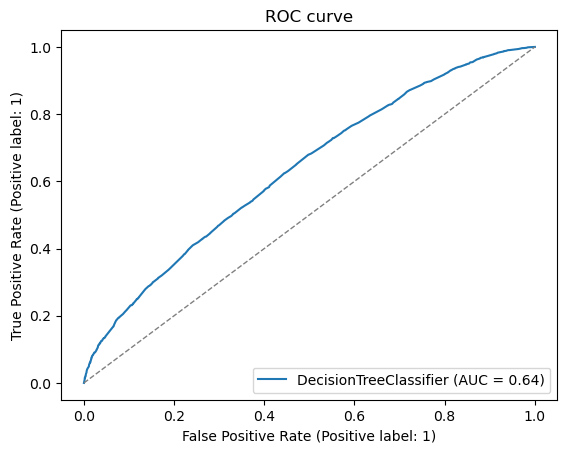

In [55]:
print_results(best_tree, X_train, X_test, y_train, y_test)

### AdaBoost with trees

In [58]:
ada_tree = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth = 1),
    n_estimators = 100,
)

ada_tree.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=100)

Classification report, training data

              precision    recall  f1-score   support

           0       0.61      0.60      0.60     59256
           1       0.60      0.61      0.61     59256

    accuracy                           0.61    118512
   macro avg       0.61      0.61      0.61    118512
weighted avg       0.61      0.61      0.61    118512

Classification report, test data

              precision    recall  f1-score   support

           0       0.61      0.60      0.61      5000
           1       0.61      0.61      0.61      5000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



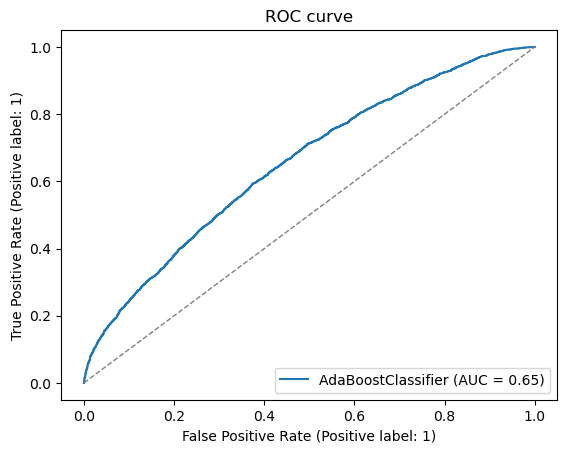

In [59]:
print_results(ada_tree, X_train, X_test, y_train, y_test)

### AdaBoost with logistic regression

In [60]:
ada_lr = AdaBoostClassifier(
    base_estimator=LogisticRegression(),
    n_estimators=100,
)

ada_lr.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=100)

Classification report, training data

              precision    recall  f1-score   support

           0       0.58      0.61      0.59     59256
           1       0.59      0.55      0.57     59256

    accuracy                           0.58    118512
   macro avg       0.58      0.58      0.58    118512
weighted avg       0.58      0.58      0.58    118512

Classification report, test data

              precision    recall  f1-score   support

           0       0.58      0.62      0.60      5000
           1       0.59      0.56      0.57      5000

    accuracy                           0.59     10000
   macro avg       0.59      0.59      0.59     10000
weighted avg       0.59      0.59      0.59     10000



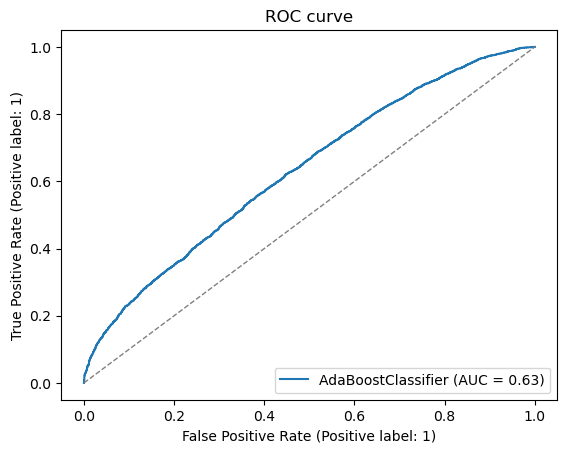

In [61]:
print_results(ada_lr, X_train, X_test, y_train, y_test)

### Random forest

In [63]:
params = {
    "n_estimators": [10, 50],
    "max_depth": [10, 30],
    "min_samples_split": [10, 30],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE), 
    param_grid=params, 
    cv=k_fold,
    scoring=f1_scorer,
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [10, 30], 'min_samples_split': [10, 30],
                         'n_estimators': [10, 50]},
             scoring=make_scorer(f1_score, pos_label=1))

In [56]:
best_forest = grid_search.best_estimator_

In [57]:
grid_search.best_params_

{'max_depth': 10, 'min_samples_leaf': 30}

Classification report, training data

              precision    recall  f1-score   support

           0       0.62      0.64      0.63     59256
           1       0.63      0.61      0.62     59256

    accuracy                           0.62    118512
   macro avg       0.62      0.62      0.62    118512
weighted avg       0.62      0.62      0.62    118512

Classification report, test data

              precision    recall  f1-score   support

           0       0.58      0.60      0.59      5000
           1       0.59      0.57      0.58      5000

    accuracy                           0.59     10000
   macro avg       0.59      0.59      0.59     10000
weighted avg       0.59      0.59      0.59     10000



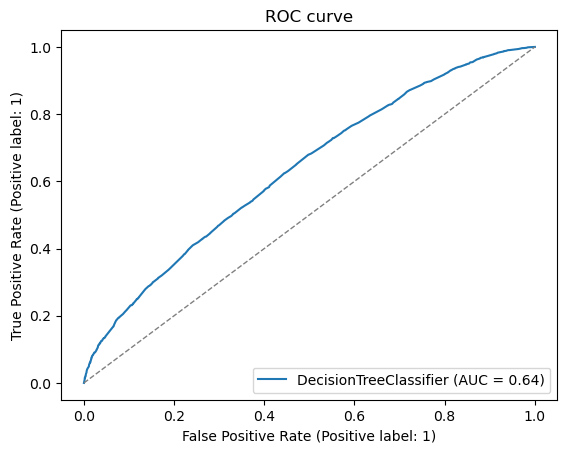

In [55]:
print_results(best_forest, X_train, X_test, y_train, y_test)

### Linear SVC

In [69]:
param_grid = {
    "C": [0.01, 100],
}

grid_search = GridSearchCV(
    estimator=LinearSVC(),
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=k_fold,
)

grid_search.fit(X_train, y_train)

C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=1, shuffle=True),
             estimator=LinearSVC(), param_grid={'C': [0.01, 100]},
             scoring=make_scorer(f1_score, pos_label=1))

In [73]:
best_lscv = grid_search.best_estimator_

Classification report, training data

              precision    recall  f1-score   support

           0       0.60      0.60      0.60     59256
           1       0.60      0.59      0.60     59256

    accuracy                           0.60    118512
   macro avg       0.60      0.60      0.60    118512
weighted avg       0.60      0.60      0.60    118512

Classification report, test data

              precision    recall  f1-score   support

           0       0.60      0.61      0.60      5000
           1       0.60      0.59      0.60      5000

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.60     10000
weighted avg       0.60      0.60      0.60     10000



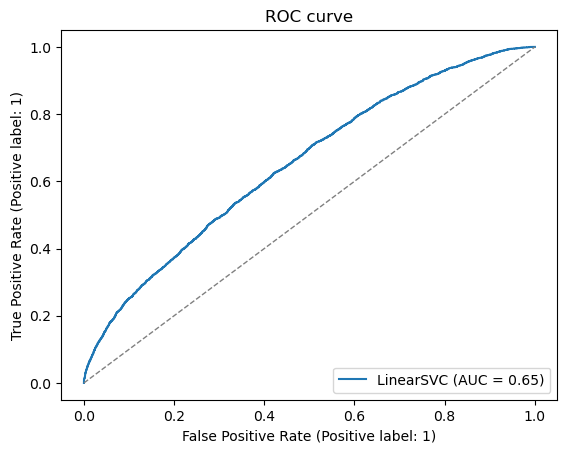

In [74]:
print_results(best_lscv, X_train, X_test, y_train, y_test)

### Gaussian SVC

In [ ]:
# param_grid = {
#     "C": [0.01, 100],
#     "gamma": [0.001, 1],
# }

# grid_search = GridSearchCV(
#     estimator=SVC(kernel='rbf'),
#     param_grid=param_grid,
#     scoring=f1_scorer,
#     cv=k_fold,
# )

# grid_search.fit(X_train, y_train)

In [ ]:
# best_gscv = grid_search.best_estimator_

In [ ]:
# SVC(kernel='rbf').fit(X_train, y_train)

In [ ]:
# print_results(best_gscv, X_train, X_test, y_train, y_test)

### Using all features

All models so far used a portion of all features that we had preselected. As the models so far have high bias and their scores are low, we can try using all input variables (original and new / engineered).

In [157]:
predictors_all = [
    # Tournament
    # "year",
    # "month",
    # "day",

    # Wrestler 2

    # "id1",
    "age1",
    "height1",
    "weight1",
    "bmi1",
    "rank1_A",
    "rank1_B",
    # "bout_outcome1",

    "tournament_wins1",
    "tournament_losses1",
    "tournament_bouts1",
    "tournament_win_percentage1",
    "tournament_win_rolling1",

    "previous_tournament_wins1",
    "previous_tournament_losses1",
    "previous_tournament_bouts1",
    "previous_tournament_win_percentage1",

    "career_wins1",
    "career_bouts1",
    "career_win_percentage1",

    "encounter_wins1",
    "encounter_win_percentage1",
    "encounter_win_rolling1",



    # Wrestler 2

    # "id2",
    "age2",
    "height2",
    "weight2",
    "bmi2",
    "rank2_A",
    "rank2_B",
    # "bout_outcome2",

    "tournament_wins2",
    "tournament_losses2",
    "tournament_bouts2",
    "tournament_win_percentage2",
    "tournament_win_rolling2",

    "previous_tournament_wins2",
    "previous_tournament_losses2",
    "previous_tournament_bouts2",
    "previous_tournament_win_percentage2",

    "career_wins2",
    "career_bouts2",
    "career_win_percentage2",

    "encounter_wins2",
    "encounter_win_percentage2",
    "encounter_win_rolling2",


    # Encounter variables
    # "encounter_id1",
    "encounter_bouts",


    # Deltas

    "age_delta",
    "bmi_delta",
    "height_delta",
    "weight_delta",

    "previous_tournament_win_percentage_delta",
    "previous_tournament_bouts_delta",

    "rank_A_delta",
    "rank_B_delta",

    "career_bouts_delta",
    "career_win_percentage_delta",

    "tournament_win_percentage_delta",
    "tournament_win_rolling_delta",
]

In [158]:
# Extract predictors and outputs
sumo_labels = sumo.bout_outcome1
sumo_attributes = sumo[predictors_all]

# Scale
scaler = MinMaxScaler()
sumo_attributes_scaled = scaler.fit_transform(sumo_attributes)

# Split
X_train, X_test, y_train, y_test = train_test_split(
        sumo_attributes_scaled, sumo_labels, test_size=10_000, stratify=sumo_labels)

In [159]:
ada_tree = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth = 1),
    n_estimators = 100,
)

ada_tree.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=100)

Classification report, training data

              precision    recall  f1-score   support

           0       0.61      0.62      0.61     59256
           1       0.61      0.61      0.61     59256

    accuracy                           0.61    118512
   macro avg       0.61      0.61      0.61    118512
weighted avg       0.61      0.61      0.61    118512

Classification report, test data

              precision    recall  f1-score   support

           0       0.60      0.62      0.61      5000
           1       0.60      0.58      0.59      5000

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.60     10000
weighted avg       0.60      0.60      0.60     10000



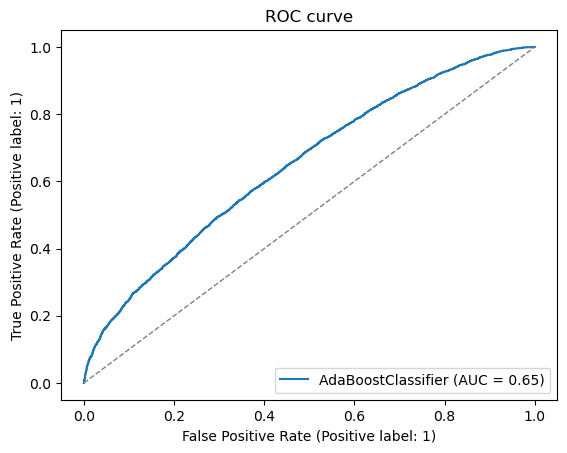

In [160]:
print_results(ada_tree, X_train, X_test, y_train, y_test)

### Fit the last two tournaments

Finally, lets predict the outcomes of the last 2 tournaments. TODO.

In [163]:
# september_tournament, july_tournament

## References

- [Info on Sumo](https://www3.nhk.or.jp/nhkworld/en/tv/sumo/qa/)
- [Makunouchi](https://www.wikiwand.com/en/Makuuchi)
- [Medium  article - building-a-sumo-wrestling-match-predictor-using-machine-learning](https://josh-sulkers.medium.com/building-a-sumo-wrestling-match-predictor-using-machine-learning-2ac95c5e20a3)
- [Used dataset in the project](https://data.world/cervus/sumo-japan)
- [Article](https://www.sciencedirect.com/science/article/pii/S2210832717301485)
- [Article](http://www.mat.ucm.es/congresos/mweek/XV_Modelling_Week/Problems/Tennis_problem.pdf)
- [Article](https://content.iospress.com/articles/journal-of-sports-analytics/jsa200463)
- [BMI](https://www.wikiwand.com/en/Body_mass_index#Physical_characteristics)
- [Article](https://www.researchgate.net/publication/334974831_Applied_Generalized_Linear_Models_for_Predicting_the_Outcome_of_Professional_Sumo_Bouts)
- [Article](https://getd.libs.uga.edu/pdfs/johnson_jeremiah_d_201208_ms.pdf)